# SST Individual Discriminability

This notebook measures discriminability of conditions for each subject, within runs.

It then takes the average discriminability across any multiple runs (I don't think we have them though).

Then we can compare discriminability against other subject-level variables.



Something similar was previously been done in `rsa_within_subj.ipynb`; it took similarity between matrices representing the averages of GNG and compared them intra-class similarity.

That file doesn't take the next step of trying to see how that similarity score might measure up against across-subject variables; it seems, because I did not find good evidence that intrasimilarity was actually higher than interclass similarity.

Conclusions:

 - maybe I should have tried discriminability, not just similarity
 - If we're interested in discriminability, then running an ML algorithm should be superior?
 - But don't rule out going back to similarity.

## TESQ

In [43]:
# setup

data_by_ppt_name = "data_by_ppt_2021_12_29.csv"

### Machine learning

First set up.

In [41]:
import pickle
from IPython.core.display import display, HTML, Markdown

In [1]:
import sys
import os
import pandas as pd
import gc

sys.path.append(os.path.abspath("../../ml/"))

from apply_loocv_and_save import *
from dev_wtp_io_utils import *
import gc
import nibabel as nib

from os import path



nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


dataset_name = 'conditions'

from nilearn.decoding import DecoderRegressor, Decoder

script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s

#get a PFC mask
#pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)


def trialtype_resp_trans_func(X):
    return(X.trial_type)



python initialized for apply_loocv_and_save


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


4


In [2]:

dataset_name = 'conditions'


brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_40subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))


relevant_mask = None

 `load_and_preprocess` has problems but I"m going to continue using it because I'm having problems with the standardization in the nilearn package. So there's not much point in deviating. We can also use the slicer in load_and_preprocess, if we get teh subject list first.
 
To get the subject list, we'll load the data once, get the list, and then load each subject individually.

In [3]:
all_subjects = load_and_preprocess(
    brain_data_filepath,
    train_test_markers_filepath,
    subjs_to_use = None,
    response_transform_func = trialtype_resp_trans_func,
    clean=None)

all_subjects['groups']

subj_list = np.unique(all_subjects['groups'])

del all_subjects
gc.collect()

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 16
subjs_to_use: 16


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


0

In [4]:
sample_subject = subj_list[0]

Here we're trying to distinguish between CorrectStop and CorrectGo. CorrectStop vs. FailedStop might be something else to try but so far we've been focusing on CorrectStop vs. CorrectGo. Discriminability between CorrectStop and FailedStop might not tell us about different things the subject is doing...

In [5]:
# iterate through each subject; for each subject:

subj_i_processed_data = load_and_preprocess(
    brain_data_filepath,
    train_test_markers_filepath,
    subjs_to_use = [sample_subject],
    response_transform_func = trialtype_resp_trans_func,
    clean="standardize")

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


In [6]:
subj_i_processed_data['y'].value_counts()

correct-go      80
correct-stop     5
Name: trial_type, dtype: int64

In [7]:
subj_i_processed_data['y'].value_counts()

correct-go      80
correct-stop     5
Name: trial_type, dtype: int64

In [8]:
from nilearn.decoding import Decoder

In [9]:
subj_i_processed_data['y'].value_counts()

correct-go      80
correct-stop     5
Name: trial_type, dtype: int64

This takes too long. For that reason, even though there are accuracy challenges, I'd like to proceed with a short-cut--we do 10-fold cross validation using the LeaveOneGroupOut feature, and ensure that Go and NoGo values are as evenly distributed across the groups as possible.

But we'll leave the capacity to do full LeaveOneOut in there because it's probably good to go back to in the future.

First to test the technical process, let's try doing just three manually-generated groups.

In [10]:
from sklearn.model_selection import StratifiedKFold
from random import randint
import math

In [11]:
#we use stratified Kfold
split_count =np.sum(subj_i_processed_data['y']=='correct-stop') 
    #could do one split per correct-stop
    #because there are generally very few of them
skf = StratifiedKFold(n_splits = 3,random_state= randint(0,math.pow(2,32)),
                      shuffle=True)
    #for testing for now we'll use 3
    
#do this separately for each outcome group

decoder = Decoder(standardize=True, 
                  cv = skf, #mask = mask,
                  n_jobs = cpus_to_use,verbose=10,
                  scoring='accuracy'
                 )

decoder_result = decoder.fit(X=subj_i_processed_data['X'],y=subj_i_processed_data['y'])


[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 85),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 85),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   28.3s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   38.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   38.4s finished


In [12]:
decoder.cv_scores_.items()

dict_items([('correct-go', [0.3448275862068966, 0.35714285714285715, 0.32142857142857145]), ('correct-stop', [0.3448275862068966, 0.35714285714285715, 0.32142857142857145])])

OK, so this isn't very good for actually closely understanding what is being classified as what; we're not getting predictions for the scores under the hood. But we can take a look at the overall predictive accuracy on a non-held-out set. Note that we can't use this for asssessing model fit (to do that we better take the average of the prediction accuracies for the folds, or run an independent test-train analysis) but we can use this to understand things like class bias or look at the image being predicted.

In [13]:
predictions = decoder.predict(subj_i_processed_data['X'])

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 85),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


In [14]:
y_pred_vs_obs = pd.DataFrame({'y_obs':subj_i_processed_data['y'],'y_pred':predictions})

In [15]:
y_pred_vs_obs.value_counts()

y_obs         y_pred      
correct-go    correct-go      45
              correct-stop    35
correct-stop  correct-stop     5
dtype: int64

In [16]:
overfit_accuracy = np.sum(y_pred_vs_obs['y_obs']==y_pred_vs_obs['y_pred'])/len(y_pred_vs_obs['y_obs'])

In [17]:
overfit_accuracy

0.5882352941176471

In [18]:
mean_cv_scores = np.mean([np.mean(c_scores) for c_name, c_scores in decoder.cv_scores_.items()])

That's interesting--despite the imbalanced classes it is not actually assigning verything to correct_stop. All the correct_stop are correctly identified as such. Odd. We might not need to deal with imbalanced classes then...? Let's see how it goes all of the subjects.

In [ ]:
results_dict = {}

for sample_subject in subj_list:
    min_splits = 3
    # iterate through each subject; for each subject:
    display("loading subject " + sample_subject)

    subj_i_processed_data = load_and_preprocess(
        brain_data_filepath,
        train_test_markers_filepath,
        subjs_to_use = [sample_subject],
        response_transform_func = trialtype_resp_trans_func,
        clean="standardize")
    
    display(subj_i_processed_data['y'].value_counts())
    
    display("setting up decoder...")
    #we use stratified Kfold
    correct_stop_count =np.sum(subj_i_processed_data['y']=='correct-stop')
    
    if correct_stop_count< min_splits:
        continue
        #could do one split per correct-stop
        #because there are generally very few of them
    skf = StratifiedKFold(n_splits = 3,random_state= randint(0,math.pow(2,32)),
                          shuffle=True)
        #for testing for now we'll use 3
        
    #do this separately for each outcome group
    decoder = Decoder(standardize=True, 
                      cv = skf, #mask = mask,
                      n_jobs = cpus_to_use,verbose=10,
                      scoring='accuracy'
                     )

    display("fitting")
    #get overfit individual predictions--only way we can assess individual predictions
    decoder_result = decoder.fit(X=subj_i_processed_data['X'],y=subj_i_processed_data['y'])
    
    display("evaluating")
    
    predictions = decoder.predict(subj_i_processed_data['X'])
    y_pred_vs_obs = pd.DataFrame({'y_obs':subj_i_processed_data['y'],'y_pred':predictions})
    overfit_accuracy = np.sum(y_pred_vs_obs['y_obs']==y_pred_vs_obs['y_pred'])/len(y_pred_vs_obs['y_obs'])
    
    #get mean_cv_scores - cross-validated scores but I'm not sure what they mean becuase the package is vague
    mean_cv_scores = np.mean([np.mean(c_scores) for c_name, c_scores in decoder.cv_scores_.items()])
    
    #alternative to this is to do our own cv stuff
    subj_discrim_results = {
        'mean_cv_scores':mean_cv_scores,
        'overfit_accuracy':overfit_accuracy,
        'overfit_y_pred_vs_obs': y_pred_vs_obs,
        'decoder_objct' : decoder
    }
    display(subj_discrim_results)
    results_dict[sample_subject] = subj_discrim_results

    

'loading subject DEV005'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      80
correct-stop     5
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 85),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 85),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   21.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   45.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   45.0s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 85),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.40024630541871914,
 'overfit_accuracy': 0.6235294117647059,
 'overfit_y_pred_vs_obs':            y_obs        y_pred
 0   correct-stop  correct-stop
 1     correct-go  correct-stop
 2     correct-go    correct-go
 3     correct-go  correct-stop
 4     correct-go    correct-go
 ..           ...           ...
 80    correct-go    correct-go
 81    correct-go    correct-go
 82    correct-go    correct-go
 83    correct-go  correct-stop
 84    correct-go  correct-stop
 
 [85 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=3691560703, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV006'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      92
correct-stop    18
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   21.3s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   31.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   31.2s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.42767767767767767,
 'overfit_accuracy': 0.7,
 'overfit_y_pred_vs_obs':             y_obs        y_pred
 85     correct-go  correct-stop
 86     correct-go    correct-go
 87     correct-go    correct-go
 88     correct-go  correct-stop
 89     correct-go    correct-go
 ..            ...           ...
 190    correct-go    correct-go
 191  correct-stop  correct-stop
 192    correct-go    correct-go
 193  correct-stop  correct-stop
 194    correct-go    correct-go
 
 [110 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=3467451064, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV009'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go    96
Name: trial_type, dtype: int64

'setting up decoder...'

'loading subject DEV010'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      94
correct-stop    13
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 107),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 107),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 107),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.32724867724867723,
 'overfit_accuracy': 0.6355140186915887,
 'overfit_y_pred_vs_obs':             y_obs        y_pred
 291  correct-stop  correct-stop
 292    correct-go    correct-go
 293    correct-go    correct-go
 294    correct-go  correct-stop
 295    correct-go  correct-stop
 ..            ...           ...
 393    correct-go    correct-go
 394    correct-go    correct-go
 395    correct-go    correct-go
 396    correct-go  correct-stop
 397    correct-go    correct-go
 
 [107 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=273723008, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV012'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go    95
Name: trial_type, dtype: int64

'setting up decoder...'

'loading subject DEV013'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      94
correct-stop    11
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   24.6s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   39.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   39.5s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3428571428571428,
 'overfit_accuracy': 0.638095238095238,
 'overfit_y_pred_vs_obs':             y_obs        y_pred
 493  correct-stop  correct-stop
 494    correct-go    correct-go
 495    correct-go  correct-stop
 496    correct-go  correct-stop
 497    correct-go  correct-stop
 ..            ...           ...
 593    correct-go  correct-stop
 594    correct-go  correct-stop
 595    correct-go    correct-go
 596    correct-go  correct-stop
 597    correct-go  correct-stop
 
 [105 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=608047818, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV014'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    14
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   19.2s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   56.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   56.0s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.4286786786786787,
 'overfit_accuracy': 0.7090909090909091,
 'overfit_y_pred_vs_obs':           y_obs        y_pred
 598  correct-go    correct-go
 599  correct-go  correct-stop
 600  correct-go  correct-stop
 601  correct-go  correct-stop
 602  correct-go    correct-go
 ..          ...           ...
 703  correct-go  correct-stop
 704  correct-go    correct-go
 705  correct-go    correct-go
 706  correct-go    correct-go
 707  correct-go    correct-go
 
 [110 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=4076227695, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV015'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      81
correct-stop    20
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 101),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 101),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   15.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   19.8s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 101),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3062982768865122,
 'overfit_accuracy': 0.7425742574257426,
 'overfit_y_pred_vs_obs':             y_obs        y_pred
 708    correct-go    correct-go
 709    correct-go    correct-go
 710    correct-go    correct-go
 711    correct-go    correct-go
 712    correct-go    correct-go
 ..            ...           ...
 804    correct-go    correct-go
 805    correct-go    correct-go
 806  correct-stop  correct-stop
 807    correct-go    correct-go
 808    correct-go    correct-go
 
 [101 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=3379204338, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV016'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      94
correct-stop    14
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    9.5s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3703703703703704,
 'overfit_accuracy': 0.7777777777777778,
 'overfit_y_pred_vs_obs':             y_obs        y_pred
 809    correct-go  correct-stop
 810    correct-go    correct-go
 811    correct-go    correct-go
 812    correct-go    correct-go
 813    correct-go    correct-go
 ..            ...           ...
 912    correct-go  correct-stop
 913    correct-go    correct-go
 914  correct-stop  correct-stop
 915    correct-go    correct-go
 916    correct-go    correct-go
 
 [108 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=2907142466, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV017'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop     4
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.5min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.595959595959596,
 'overfit_accuracy': 0.7171717171717171,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 917   correct-stop  correct-stop
 918     correct-go    correct-go
 919     correct-go    correct-go
 920     correct-go    correct-go
 921     correct-go    correct-go
 ...            ...           ...
 1011    correct-go    correct-go
 1012    correct-go    correct-go
 1013  correct-stop  correct-stop
 1014    correct-go    correct-go
 1015    correct-go    correct-go
 
 [99 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=3730459788, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV018'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    15
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   35.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  3.1min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3963963963963964,
 'overfit_accuracy': 0.6936936936936937,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1016    correct-go    correct-go
 1017    correct-go  correct-stop
 1018    correct-go    correct-go
 1019    correct-go    correct-go
 1020    correct-go    correct-go
 ...            ...           ...
 1122  correct-stop  correct-stop
 1123    correct-go    correct-go
 1124    correct-go    correct-go
 1125    correct-go  correct-stop
 1126    correct-go    correct-go
 
 [111 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=3701094360, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV019'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    17
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 113),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 113),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   26.9s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.5min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 113),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.39758179231863444,
 'overfit_accuracy': 0.672566371681416,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1127    correct-go  correct-stop
 1128    correct-go  correct-stop
 1129    correct-go  correct-stop
 1130    correct-go  correct-stop
 1131    correct-go    correct-go
 ...            ...           ...
 1235    correct-go    correct-go
 1236    correct-go  correct-stop
 1237  correct-stop  correct-stop
 1238    correct-go    correct-go
 1239    correct-go    correct-go
 
 [113 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=52820077, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV021'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      94
correct-stop     8
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 102),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 102),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   17.9s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   48.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   48.4s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 102),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.37254901960784315,
 'overfit_accuracy': 0.6862745098039216,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1240    correct-go    correct-go
 1241    correct-go  correct-stop
 1242    correct-go  correct-stop
 1243    correct-go    correct-go
 1244    correct-go    correct-go
 ...            ...           ...
 1337    correct-go    correct-go
 1338    correct-go    correct-go
 1339    correct-go    correct-go
 1340    correct-go  correct-stop
 1341  correct-stop  correct-stop
 
 [102 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=2919178262, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV022'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      80
correct-stop    19
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   28.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   50.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   50.5s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.4343434343434343,
 'overfit_accuracy': 0.7070707070707071,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1342    correct-go  correct-stop
 1343    correct-go  correct-stop
 1344    correct-go  correct-stop
 1345    correct-go    correct-go
 1346    correct-go    correct-go
 ...            ...           ...
 1436    correct-go  correct-stop
 1437    correct-go  correct-stop
 1438  correct-stop  correct-stop
 1439    correct-go    correct-go
 1440    correct-go    correct-go
 
 [99 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=2220138767, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV023'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    13
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   30.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.4min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.4259259259259259,
 'overfit_accuracy': 0.7129629629629629,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1441    correct-go    correct-go
 1442    correct-go    correct-go
 1443    correct-go  correct-stop
 1444    correct-go  correct-stop
 1445    correct-go    correct-go
 ...            ...           ...
 1544    correct-go    correct-go
 1545    correct-go    correct-go
 1546    correct-go  correct-stop
 1547    correct-go    correct-go
 1548  correct-stop  correct-stop
 
 [108 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=4106998152, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV024'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    16
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   22.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3963963963963964,
 'overfit_accuracy': 0.7117117117117117,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1549    correct-go    correct-go
 1550    correct-go  correct-stop
 1551    correct-go  correct-stop
 1552    correct-go  correct-stop
 1553    correct-go    correct-go
 ...            ...           ...
 1655    correct-go    correct-go
 1656    correct-go    correct-go
 1657    correct-go    correct-go
 1658  correct-stop  correct-stop
 1659    correct-go    correct-go
 
 [111 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=375378979, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV025'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go    96
Name: trial_type, dtype: int64

'setting up decoder...'

'loading subject DEV026'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    16
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


In [20]:
results_dict = {}

for sample_subject in subj_list:
    min_splits = 3
    # iterate through each subject; for each subject:
    display("loading subject " + sample_subject)

    subj_i_processed_data = load_and_preprocess(
        brain_data_filepath,
        train_test_markers_filepath,
        subjs_to_use = [sample_subject],
        response_transform_func = trialtype_resp_trans_func,
        clean="standardize")
    
    display(subj_i_processed_data['y'].value_counts())
    
    display("setting up decoder...")
    #we use stratified Kfold
    correct_stop_count =np.sum(subj_i_processed_data['y']=='correct-stop')
    
    if correct_stop_count< min_splits:
        continue
        #could do one split per correct-stop
        #because there are generally very few of them
    skf = StratifiedKFold(n_splits = 3,random_state= randint(0,math.pow(2,32)),
                          shuffle=True)
        #for testing for now we'll use 3
        
    #do this separately for each outcome group
    decoder = Decoder(standardize=True, 
                      cv = skf, #mask = mask,
                      n_jobs = cpus_to_use,verbose=10,
                      scoring='accuracy'
                     )

    display("fitting")
    #get overfit individual predictions--only way we can assess individual predictions
    decoder_result = decoder.fit(X=subj_i_processed_data['X'],y=subj_i_processed_data['y'])
    
    display("evaluating")
    
    predictions = decoder.predict(subj_i_processed_data['X'])
    y_pred_vs_obs = pd.DataFrame({'y_obs':subj_i_processed_data['y'],'y_pred':predictions})
    overfit_accuracy = np.sum(y_pred_vs_obs['y_obs']==y_pred_vs_obs['y_pred'])/len(y_pred_vs_obs['y_obs'])
    
    #get mean_cv_scores - cross-validated scores but I'm not sure what they mean becuase the package is vague
    mean_cv_scores = np.mean([np.mean(c_scores) for c_name, c_scores in decoder.cv_scores_.items()])
    
    #alternative to this is to do our own cv stuff
    subj_discrim_results = {
        'mean_cv_scores':mean_cv_scores,
        'overfit_accuracy':overfit_accuracy,
        'overfit_y_pred_vs_obs': y_pred_vs_obs,
        'decoder_objct' : decoder
    }
    display(subj_discrim_results)
    results_dict[sample_subject] = subj_discrim_results

    

'loading subject DEV005'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      80
correct-stop     5
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 85),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 85),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   15.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   36.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   36.8s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 85),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.35303776683087024,
 'overfit_accuracy': 0.6470588235294118,
 'overfit_y_pred_vs_obs':            y_obs        y_pred
 0   correct-stop  correct-stop
 1     correct-go  correct-stop
 2     correct-go    correct-go
 3     correct-go  correct-stop
 4     correct-go    correct-go
 ..           ...           ...
 80    correct-go    correct-go
 81    correct-go    correct-go
 82    correct-go    correct-go
 83    correct-go    correct-go
 84    correct-go  correct-stop
 
 [85 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=445898742, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV006'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      92
correct-stop    18
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   22.9s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   48.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   48.3s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.4281781781781782,
 'overfit_accuracy': 0.7454545454545455,
 'overfit_y_pred_vs_obs':             y_obs        y_pred
 85     correct-go  correct-stop
 86     correct-go    correct-go
 87     correct-go    correct-go
 88     correct-go    correct-go
 89     correct-go    correct-go
 ..            ...           ...
 190    correct-go    correct-go
 191  correct-stop  correct-stop
 192    correct-go    correct-go
 193  correct-stop  correct-stop
 194    correct-go    correct-go
 
 [110 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=826470077, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV009'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go    96
Name: trial_type, dtype: int64

'setting up decoder...'

'loading subject DEV010'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      94
correct-stop    13
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 107),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 107),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   30.9s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   58.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   58.3s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 107),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3555555555555556,
 'overfit_accuracy': 0.616822429906542,
 'overfit_y_pred_vs_obs':             y_obs        y_pred
 291  correct-stop  correct-stop
 292    correct-go    correct-go
 293    correct-go    correct-go
 294    correct-go  correct-stop
 295    correct-go  correct-stop
 ..            ...           ...
 393    correct-go    correct-go
 394    correct-go    correct-go
 395    correct-go    correct-go
 396    correct-go  correct-stop
 397    correct-go  correct-stop
 
 [107 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1670243871, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV012'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go    95
Name: trial_type, dtype: int64

'setting up decoder...'

'loading subject DEV013'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      94
correct-stop    11
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   26.4s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.5min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.4000000000000001,
 'overfit_accuracy': 0.6666666666666666,
 'overfit_y_pred_vs_obs':             y_obs        y_pred
 493  correct-stop  correct-stop
 494    correct-go    correct-go
 495    correct-go    correct-go
 496    correct-go  correct-stop
 497    correct-go  correct-stop
 ..            ...           ...
 593    correct-go    correct-go
 594    correct-go    correct-go
 595    correct-go    correct-go
 596    correct-go  correct-stop
 597    correct-go  correct-stop
 
 [105 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=3106178954, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV014'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    14
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   21.2s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   44.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   44.3s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.36361361361361366,
 'overfit_accuracy': 0.6818181818181818,
 'overfit_y_pred_vs_obs':           y_obs        y_pred
 598  correct-go    correct-go
 599  correct-go  correct-stop
 600  correct-go  correct-stop
 601  correct-go  correct-stop
 602  correct-go    correct-go
 ..          ...           ...
 703  correct-go  correct-stop
 704  correct-go    correct-go
 705  correct-go    correct-go
 706  correct-go    correct-go
 707  correct-go    correct-go
 
 [110 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=4108978451, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV015'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      81
correct-stop    20
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 101),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 101),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   19.2s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   37.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   37.6s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 101),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.38621509209744503,
 'overfit_accuracy': 0.7227722772277227,
 'overfit_y_pred_vs_obs':             y_obs        y_pred
 708    correct-go  correct-stop
 709    correct-go  correct-stop
 710    correct-go  correct-stop
 711    correct-go    correct-go
 712    correct-go  correct-stop
 ..            ...           ...
 804    correct-go    correct-go
 805    correct-go    correct-go
 806  correct-stop  correct-stop
 807    correct-go    correct-go
 808    correct-go    correct-go
 
 [101 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1204643955, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV016'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      94
correct-stop    14
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   13.5s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.6s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3611111111111111,
 'overfit_accuracy': 0.7314814814814815,
 'overfit_y_pred_vs_obs':             y_obs        y_pred
 809    correct-go  correct-stop
 810    correct-go  correct-stop
 811    correct-go  correct-stop
 812    correct-go  correct-stop
 813    correct-go    correct-go
 ..            ...           ...
 912    correct-go  correct-stop
 913    correct-go    correct-go
 914  correct-stop  correct-stop
 915    correct-go    correct-go
 916    correct-go    correct-go
 
 [108 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=4180267472, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV017'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop     4
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.4min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.6363636363636364,
 'overfit_accuracy': 0.7676767676767676,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 917   correct-stop  correct-stop
 918     correct-go  correct-stop
 919     correct-go    correct-go
 920     correct-go    correct-go
 921     correct-go    correct-go
 ...            ...           ...
 1011    correct-go    correct-go
 1012    correct-go    correct-go
 1013  correct-stop  correct-stop
 1014    correct-go    correct-go
 1015    correct-go    correct-go
 
 [99 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=2239515698, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV018'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    15
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   20.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   45.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   45.5s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3513513513513513,
 'overfit_accuracy': 0.6306306306306306,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1016    correct-go    correct-go
 1017    correct-go    correct-go
 1018    correct-go  correct-stop
 1019    correct-go  correct-stop
 1020    correct-go  correct-stop
 ...            ...           ...
 1122  correct-stop  correct-stop
 1123    correct-go    correct-go
 1124    correct-go    correct-go
 1125    correct-go  correct-stop
 1126    correct-go  correct-stop
 
 [111 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1627055239, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV019'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    17
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 113),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 113),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   28.2s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   46.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   46.7s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 113),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.33617828354670465,
 'overfit_accuracy': 0.6548672566371682,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1127    correct-go    correct-go
 1128    correct-go  correct-stop
 1129    correct-go  correct-stop
 1130    correct-go  correct-stop
 1131    correct-go    correct-go
 ...            ...           ...
 1235    correct-go    correct-go
 1236    correct-go    correct-go
 1237  correct-stop  correct-stop
 1238    correct-go    correct-go
 1239    correct-go    correct-go
 
 [113 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1572897284, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV021'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      94
correct-stop     8
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 102),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 102),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   13.6s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   32.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   32.0s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 102),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.38235294117647056,
 'overfit_accuracy': 0.6666666666666666,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1240    correct-go    correct-go
 1241    correct-go  correct-stop
 1242    correct-go  correct-stop
 1243    correct-go    correct-go
 1244    correct-go    correct-go
 ...            ...           ...
 1337    correct-go    correct-go
 1338    correct-go    correct-go
 1339    correct-go    correct-go
 1340    correct-go  correct-stop
 1341  correct-stop    correct-go
 
 [102 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=4184897993, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV022'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      80
correct-stop    19
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   20.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.2min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 99),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.38383838383838387,
 'overfit_accuracy': 0.7474747474747475,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1342    correct-go  correct-stop
 1343    correct-go  correct-stop
 1344    correct-go    correct-go
 1345    correct-go  correct-stop
 1346    correct-go    correct-go
 ...            ...           ...
 1436    correct-go  correct-stop
 1437    correct-go    correct-go
 1438  correct-stop  correct-stop
 1439    correct-go    correct-go
 1440    correct-go    correct-go
 
 [99 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=3123178667, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV023'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    13
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   29.9s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.3min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.2962962962962963,
 'overfit_accuracy': 0.6759259259259259,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1441    correct-go    correct-go
 1442    correct-go    correct-go
 1443    correct-go  correct-stop
 1444    correct-go  correct-stop
 1445    correct-go  correct-stop
 ...            ...           ...
 1544    correct-go    correct-go
 1545    correct-go    correct-go
 1546    correct-go  correct-stop
 1547    correct-go    correct-go
 1548  correct-stop  correct-stop
 
 [108 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1342385010, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV024'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    16
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   29.5s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.3min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3963963963963964,
 'overfit_accuracy': 0.6486486486486487,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1549    correct-go  correct-stop
 1550    correct-go  correct-stop
 1551    correct-go  correct-stop
 1552    correct-go  correct-stop
 1553    correct-go    correct-go
 ...            ...           ...
 1655    correct-go  correct-stop
 1656    correct-go  correct-stop
 1657    correct-go  correct-stop
 1658  correct-stop  correct-stop
 1659    correct-go    correct-go
 
 [111 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1807451674, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV025'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go    96
Name: trial_type, dtype: int64

'setting up decoder...'

'loading subject DEV026'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    16
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   47.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.5min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.44144144144144143,
 'overfit_accuracy': 0.6936936936936937,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1756    correct-go    correct-go
 1757    correct-go  correct-stop
 1758    correct-go  correct-stop
 1759    correct-go  correct-stop
 1760    correct-go    correct-go
 ...            ...           ...
 1862    correct-go    correct-go
 1863  correct-stop  correct-stop
 1864    correct-go    correct-go
 1865  correct-stop  correct-stop
 1866    correct-go    correct-go
 
 [111 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=3495145861, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV027'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      94
correct-stop    20
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 114),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 114),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   20.0s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 114),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.46491228070175433,
 'overfit_accuracy': 0.6403508771929824,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1867  correct-stop  correct-stop
 1868    correct-go  correct-stop
 1869  correct-stop  correct-stop
 1870    correct-go  correct-stop
 1871    correct-go    correct-go
 ...            ...           ...
 1976    correct-go  correct-stop
 1977    correct-go    correct-go
 1978    correct-go  correct-stop
 1979  correct-stop  correct-stop
 1980    correct-go    correct-go
 
 [114 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=2578483119, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV028'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    13
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 109),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 109),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.0s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 109),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.4684684684684684,
 'overfit_accuracy': 0.7522935779816514,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 1981    correct-go  correct-stop
 1982    correct-go    correct-go
 1983    correct-go    correct-go
 1984    correct-go  correct-stop
 1985    correct-go    correct-go
 ...            ...           ...
 2085  correct-stop  correct-stop
 2086    correct-go    correct-go
 2087    correct-go    correct-go
 2088    correct-go    correct-go
 2089    correct-go    correct-go
 
 [109 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=2646733365, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV029'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    16
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 112),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 112),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   38.4s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   41.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   41.2s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 112),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.41085822664770033,
 'overfit_accuracy': 0.6875,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 2090    correct-go  correct-stop
 2091    correct-go  correct-stop
 2092    correct-go  correct-stop
 2093    correct-go    correct-go
 2094    correct-go    correct-go
 ...            ...           ...
 2197    correct-go  correct-stop
 2198    correct-go    correct-go
 2199  correct-stop  correct-stop
 2200    correct-go    correct-go
 2201    correct-go    correct-go
 
 [112 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=4168791360, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV030'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    15
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   14.3s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   35.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   35.8s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3813813813813814,
 'overfit_accuracy': 0.7454545454545455,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 2202  correct-stop  correct-stop
 2203    correct-go    correct-go
 2204    correct-go    correct-go
 2205    correct-go  correct-stop
 2206    correct-go    correct-go
 ...            ...           ...
 2307    correct-go    correct-go
 2308    correct-go  correct-stop
 2309    correct-go    correct-go
 2310    correct-go    correct-go
 2311  correct-stop  correct-stop
 
 [110 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=2769047070, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV034'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop     9
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  3.2min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.4666666666666666,
 'overfit_accuracy': 0.6571428571428571,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 2312    correct-go  correct-stop
 2313  correct-stop  correct-stop
 2314    correct-go  correct-stop
 2315    correct-go  correct-stop
 2316    correct-go    correct-go
 ...            ...           ...
 2412    correct-go  correct-stop
 2413    correct-go    correct-go
 2414    correct-go    correct-go
 2415    correct-go    correct-go
 2416    correct-go    correct-go
 
 [105 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1908626223, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV035'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    15
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   26.9s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   54.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   54.6s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 111),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3873873873873874,
 'overfit_accuracy': 0.6936936936936937,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 2417    correct-go    correct-go
 2418    correct-go    correct-go
 2419    correct-go  correct-stop
 2420    correct-go  correct-stop
 2421    correct-go    correct-go
 ...            ...           ...
 2523    correct-go    correct-go
 2524    correct-go  correct-stop
 2525    correct-go  correct-stop
 2526    correct-go    correct-go
 2527  correct-stop  correct-stop
 
 [111 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=701099764, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV036'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop     8
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 103),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 103),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   50.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.3min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 103),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.39775910364145656,
 'overfit_accuracy': 0.6213592233009708,
 'overfit_y_pred_vs_obs':            y_obs        y_pred
 2528  correct-go  correct-stop
 2529  correct-go  correct-stop
 2530  correct-go    correct-go
 2531  correct-go    correct-go
 2532  correct-go    correct-go
 ...          ...           ...
 2626  correct-go  correct-stop
 2627  correct-go    correct-go
 2628  correct-go    correct-go
 2629  correct-go    correct-go
 2630  correct-go    correct-go
 
 [103 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1882545040, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV039'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      87
correct-stop     9
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 96),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 96),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   37.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.7min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 96),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.375,
 'overfit_accuracy': 0.6145833333333334,
 'overfit_y_pred_vs_obs':            y_obs        y_pred
 2631  correct-go    correct-go
 2632  correct-go  correct-stop
 2633  correct-go  correct-stop
 2634  correct-go    correct-go
 2635  correct-go    correct-go
 ...          ...           ...
 2722  correct-go  correct-stop
 2723  correct-go    correct-go
 2724  correct-go    correct-go
 2725  correct-go    correct-go
 2726  correct-go    correct-go
 
 [96 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=4076329488, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV040'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    17
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 112),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 112),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   32.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.2min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 112),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.33119962067330494,
 'overfit_accuracy': 0.6696428571428571,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 2727  correct-stop    correct-go
 2728    correct-go    correct-go
 2729    correct-go  correct-stop
 2730    correct-go    correct-go
 2731    correct-go    correct-go
 ...            ...           ...
 2834    correct-go    correct-go
 2835    correct-go  correct-stop
 2836    correct-go  correct-stop
 2837    correct-go    correct-go
 2838  correct-stop  correct-stop
 
 [112 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=2719170798, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV041'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    16
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 112),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 112),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   42.4s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   58.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   58.9s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 112),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.42816500711237554,
 'overfit_accuracy': 0.6428571428571429,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 2839    correct-go    correct-go
 2840    correct-go    correct-go
 2841    correct-go  correct-stop
 2842    correct-go  correct-stop
 2843    correct-go  correct-stop
 ...            ...           ...
 2946    correct-go    correct-go
 2947    correct-go  correct-stop
 2948    correct-go  correct-stop
 2949    correct-go    correct-go
 2950  correct-stop    correct-go
 
 [112 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=365501558, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV042'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      85
correct-stop    20
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   17.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.2s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.40952380952380957,
 'overfit_accuracy': 0.7333333333333333,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 2951    correct-go  correct-stop
 2952  correct-stop  correct-stop
 2953    correct-go  correct-stop
 2954    correct-go  correct-stop
 2955    correct-go  correct-stop
 ...            ...           ...
 3051    correct-go    correct-go
 3052    correct-go    correct-go
 3053  correct-stop  correct-stop
 3054    correct-go    correct-go
 3055  correct-stop  correct-stop
 
 [105 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1314561481, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV043'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    13
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 109),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 109),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   41.8s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.4min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 109),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.32982982982982983,
 'overfit_accuracy': 0.6055045871559633,
 'overfit_y_pred_vs_obs':            y_obs        y_pred
 3056  correct-go  correct-stop
 3057  correct-go    correct-go
 3058  correct-go    correct-go
 3059  correct-go  correct-stop
 3060  correct-go    correct-go
 ...          ...           ...
 3160  correct-go  correct-stop
 3161  correct-go    correct-go
 3162  correct-go    correct-go
 3163  correct-go  correct-stop
 3164  correct-go  correct-stop
 
 [109 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=2777945611, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV046'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    11
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 106),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 106),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   42.5s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 106),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.341005291005291,
 'overfit_accuracy': 0.6415094339622641,
 'overfit_y_pred_vs_obs':            y_obs        y_pred
 3165  correct-go  correct-stop
 3166  correct-go  correct-stop
 3167  correct-go  correct-stop
 3168  correct-go  correct-stop
 3169  correct-go    correct-go
 ...          ...           ...
 3266  correct-go    correct-go
 3267  correct-go    correct-go
 3268  correct-go    correct-go
 3269  correct-go    correct-go
 3270  correct-go    correct-go
 
 [106 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=3978225774, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV048'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      90
correct-stop    18
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   23.9s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   50.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   50.8s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 108),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.28703703703703703,
 'overfit_accuracy': 0.6574074074074074,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 3271  correct-stop  correct-stop
 3272    correct-go  correct-stop
 3273    correct-go    correct-go
 3274    correct-go    correct-go
 3275    correct-go    correct-go
 ...            ...           ...
 3374    correct-go    correct-go
 3375    correct-go  correct-stop
 3376    correct-go  correct-stop
 3377    correct-go    correct-go
 3378  correct-stop  correct-stop
 
 [108 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1786081701, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV049'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      73
correct-stop    18
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 91),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 91),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   31.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   31.6s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 91),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.4283154121863799,
 'overfit_accuracy': 0.7142857142857143,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 3379  correct-stop  correct-stop
 3380    correct-go  correct-stop
 3381  correct-stop  correct-stop
 3382    correct-go  correct-stop
 3383    correct-go    correct-go
 ...            ...           ...
 3465    correct-go  correct-stop
 3466    correct-go    correct-go
 3467  correct-stop  correct-stop
 3468    correct-go    correct-go
 3469    correct-go    correct-go
 
 [91 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=3116134961, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV050'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    21
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 116),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 116),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   28.3s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 116),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.36212325686009894,
 'overfit_accuracy': 0.7155172413793104,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 3470    correct-go    correct-go
 3471    correct-go    correct-go
 3472    correct-go  correct-stop
 3473    correct-go  correct-stop
 3474    correct-go    correct-go
 ...            ...           ...
 3581    correct-go    correct-go
 3582    correct-go    correct-go
 3583    correct-go  correct-stop
 3584    correct-go  correct-stop
 3585  correct-stop  correct-stop
 
 [116 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=3305736826, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV051'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    12
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 107),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 107),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   26.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   45.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   45.9s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 107),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3653439153439153,
 'overfit_accuracy': 0.6915887850467289,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 3586    correct-go    correct-go
 3587    correct-go  correct-stop
 3588    correct-go  correct-stop
 3589    correct-go  correct-stop
 3590    correct-go    correct-go
 ...            ...           ...
 3688    correct-go    correct-go
 3689    correct-go    correct-go
 3690    correct-go  correct-stop
 3691    correct-go    correct-go
 3692  correct-stop  correct-stop
 
 [107 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1740850654, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV052'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      91
correct-stop    19
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   52.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.4min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 110),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.3275775775775776,
 'overfit_accuracy': 0.6818181818181818,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 3693    correct-go  correct-stop
 3694    correct-go  correct-stop
 3695    correct-go  correct-stop
 3696    correct-go  correct-stop
 3697    correct-go    correct-go
 ...            ...           ...
 3798    correct-go    correct-go
 3799  correct-stop  correct-stop
 3800    correct-go    correct-go
 3801  correct-stop  correct-stop
 3802    correct-go    correct-go
 
 [110 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=4279871823, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV053'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    18
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 114),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 114),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   24.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.8min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 114),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.41228070175438597,
 'overfit_accuracy': 0.7192982456140351,
 'overfit_y_pred_vs_obs':              y_obs        y_pred
 3803    correct-go    correct-go
 3804    correct-go    correct-go
 3805    correct-go  correct-stop
 3806    correct-go  correct-stop
 3807    correct-go    correct-go
 ...            ...           ...
 3912    correct-go    correct-go
 3913    correct-go    correct-go
 3914    correct-go  correct-stop
 3915    correct-go    correct-go
 3916  correct-stop  correct-stop
 
 [114 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1060929389, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV055'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop     2
Name: trial_type, dtype: int64

'setting up decoder...'

'loading subject DEV056'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      95
correct-stop    10
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   21.2s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   56.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   56.6s finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 105),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.39999999999999997,
 'overfit_accuracy': 0.6285714285714286,
 'overfit_y_pred_vs_obs':            y_obs        y_pred
 4015  correct-go  correct-stop
 4016  correct-go  correct-stop
 4017  correct-go    correct-go
 4018  correct-go    correct-go
 4019  correct-go    correct-go
 ...          ...           ...
 4115  correct-go  correct-stop
 4116  correct-go    correct-go
 4117  correct-go    correct-go
 4118  correct-go    correct-go
 4119  correct-go    correct-go
 
 [105 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=2505248299, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

'loading subject DEV057'

checked for intersection and no intersection between the brain data and the subjects was found.
there were 40 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
subjs_to_use: 64
clean: 60
Brain_Data_allsubs: 48


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


4229
4229


correct-go      96
correct-stop    13
Name: trial_type, dtype: int64

'setting up decoder...'

'fitting'

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97, 109),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 109),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   38.3s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.4min finished


'evaluating'

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 109),
affine=array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


{'mean_cv_scores': 0.35835835835835833,
 'overfit_accuracy': 0.6605504587155964,
 'overfit_y_pred_vs_obs':            y_obs        y_pred
 4120  correct-go    correct-go
 4121  correct-go  correct-stop
 4122  correct-go  correct-stop
 4123  correct-go  correct-stop
 4124  correct-go    correct-go
 ...          ...           ...
 4224  correct-go  correct-stop
 4225  correct-go    correct-go
 4226  correct-go    correct-go
 4227  correct-go    correct-go
 4228  correct-go    correct-go
 
 [109 rows x 2 columns],
 'decoder_objct': Decoder(cv=StratifiedKFold(n_splits=3, random_state=1515222072, shuffle=True),
         estimator=LinearSVC(max_iter=10000.0), memory=Memory(location=None),
         n_jobs=3, scoring='accuracy', verbose=10)}

In [34]:
summary_results = pd.concat([pd.DataFrame({
    'subid':k,
    'overfit_accuracy':[v['overfit_accuracy']],
    'mean_cv_scores':[v['mean_cv_scores']]}) 

                             for k,v in results_dict.items()])

In [38]:
import matplotlib.pyplot as plt

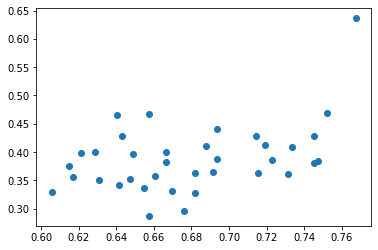

In [39]:
plt.scatter(summary_results['overfit_accuracy'],summary_results['mean_cv_scores'])

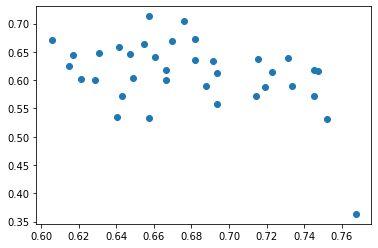

In [40]:
plt.scatter(summary_results['overfit_accuracy'],1-summary_results['mean_cv_scores'])

How to deal with imbalanced classes?
We're using svc. One solution: https://chrisalbon.com/code/machine_learning/support_vector_machines/imbalanced_classes_in_svm/

### analyze

In [55]:
from analyze_results import remove_selected_outliers

In [ ]:



# output discriminability for each subject.




In [63]:
summary_results2 = summary_results.rename(columns={
    'mean_cv_scores':'discriminability_mean_cv_scores',
    'overfit_accuracy':'discriminability_overfit_accuracy'})

In [48]:
# correlate discriminability against shit we care about.

individual_differences = pd.read_csv(ml_data_folderpath + "/" + data_by_ppt_name)
individual_differences = individual_differences.rename(columns={'SID':'subid'})
individual_differences['wave']=1
#individual_differences['wave'] = individual_differences['wave'].astype(object) # for compatibility with the wave column in the dataset


In [64]:
ind_div_combined = summary_results2.merge(individual_differences)

In [84]:

def remove_selected_outliers_tesq_study(ind_div_combined,show_plot=False):
    idc_outliers_removed = remove_selected_outliers(ind_div_combined,
    ['discriminability_overfit_accuracy','discriminability_mean_cv_scores',
        'BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies',
     'SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
     'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction',
     'TESQ_E_goal_and_rule_setting','EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look',
     'SRHI_unhealthy',
     'cancer_promoting_minus_preventing_FFQ','bf_1'],
    show_plot=show_plot)
    return(idc_outliers_removed)

#### discriminability_overfit_accuracy

0.6727843915343915 0.16102172020436747 0.5117626713300241 0.833806111738759


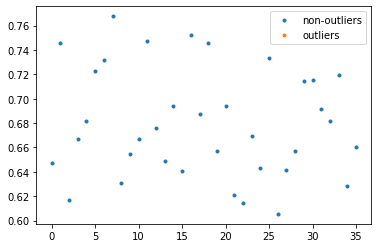

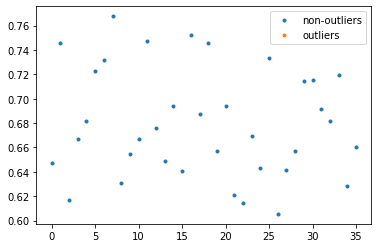

0.6727843915343915 0.16102172020436747 0.5117626713300241 0.833806111738759


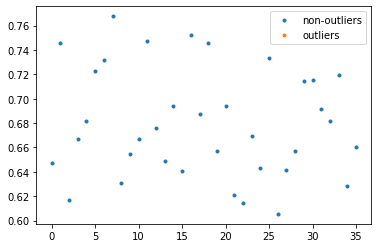

36 , 36


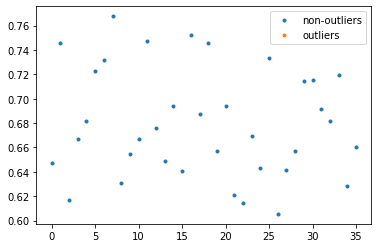

36 , 36


#### discriminability_mean_cv_scores

0.3830956625074272 0.1272904868508514 0.2558051756565758 0.5103861493582786


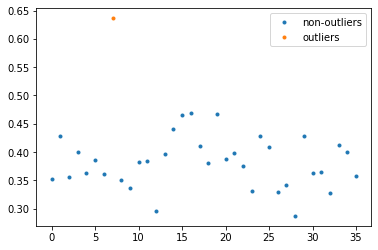

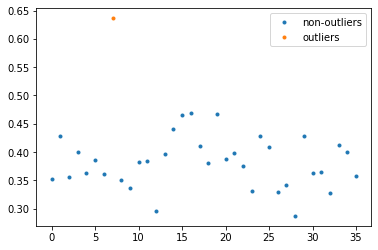

0.3830956625074272 0.1272904868508514 0.2558051756565758 0.5103861493582786


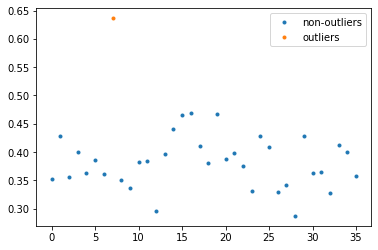

36 , 35
0.38235294117647056 0.12413739407763533 0.2582155470988352 0.5064903352541059


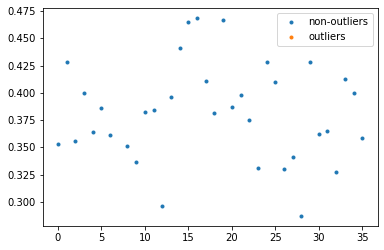

35 , 35


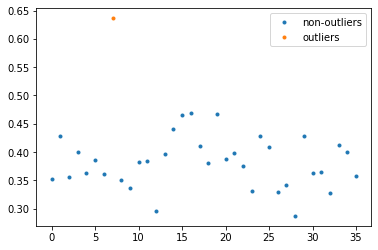

36 , 35


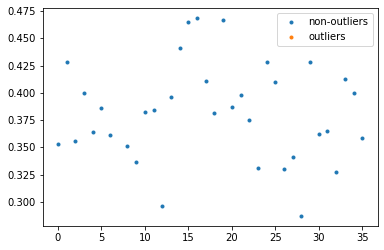

35 , 35


#### BFI_extraversion

26.0 15.522029319454926 10.477970680545074 41.52202931945493


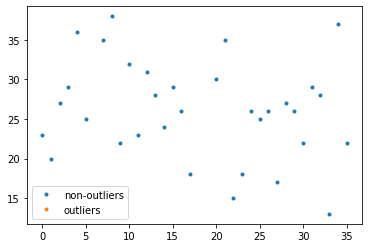

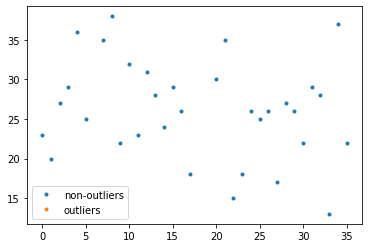

26.0 15.522029319454926 10.477970680545074 41.52202931945493


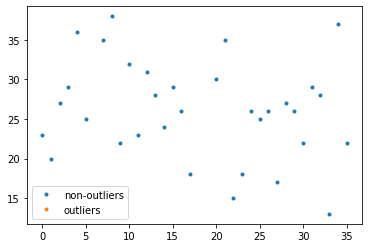

33 , 33


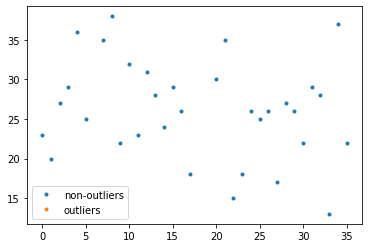

33 , 33


#### RMQ_locomotion

4.58333333333333 1.8507741058173361 2.7325592275159942 6.434107439150667


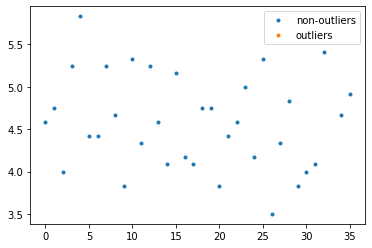

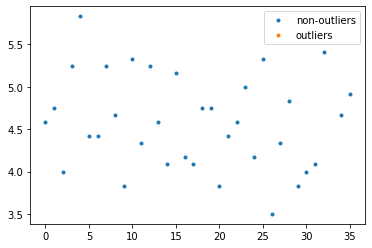

4.58333333333333 1.8507741058173361 2.7325592275159942 6.434107439150667


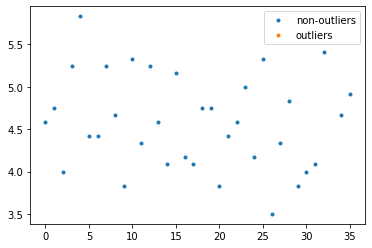

35 , 35


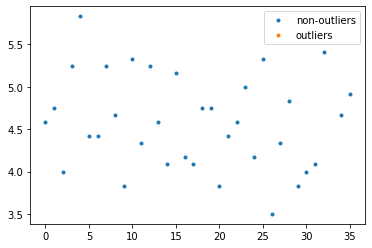

35 , 35


#### ses_aggregate

-0.2903052881717804 1.6981817788325901 -1.9884870670043706 1.4078764906608097


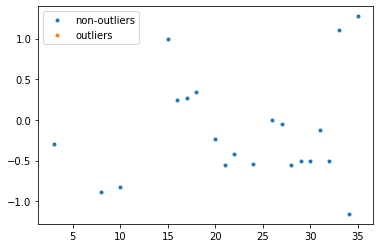

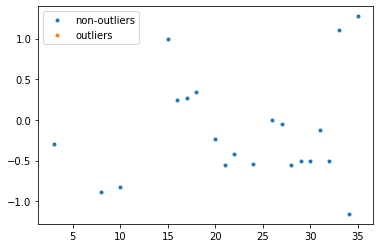

-0.2903052881717804 1.6981817788325901 -1.9884870670043706 1.4078764906608097


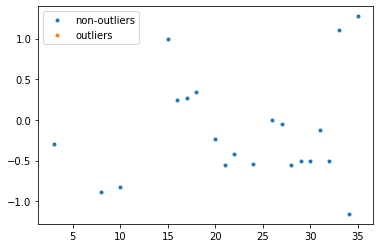

21 , 21


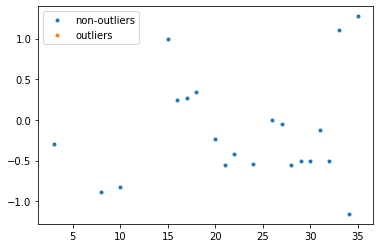

21 , 21


#### PLAN_cognitive_strategies

3.8 2.660919311906559 1.1390806880934408 6.460919311906559


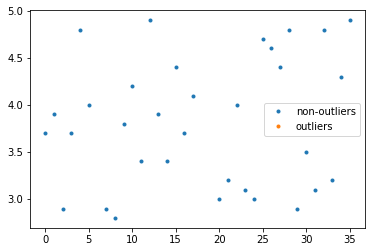

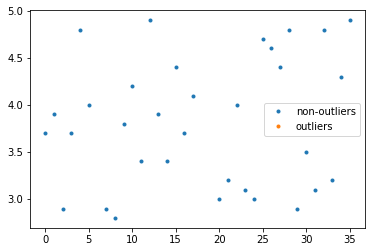

3.8 2.660919311906559 1.1390806880934408 6.460919311906559


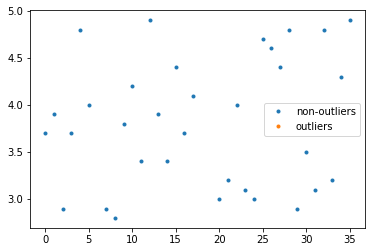

33 , 33


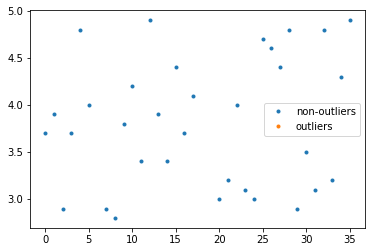

33 , 33


#### SST_SSRT

320.1792909974757 220.4277009770638 99.75159002041187 540.6069919745395


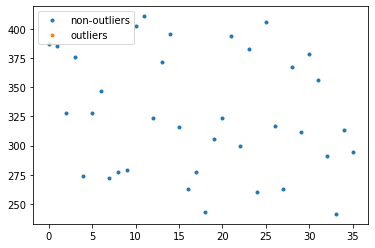

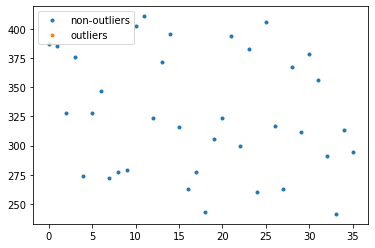

320.1792909974757 220.4277009770638 99.75159002041187 540.6069919745395


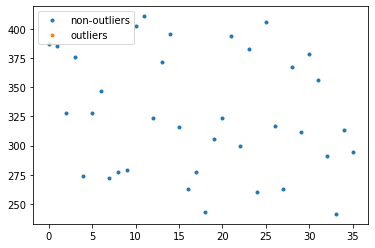

36 , 36


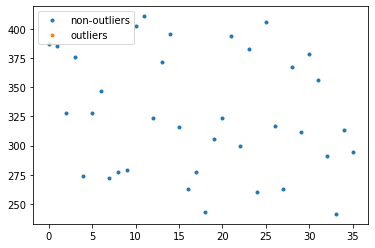

36 , 36


#### BIS_11

63.0 31.115411195577053 31.884588804422947 94.11541119557705


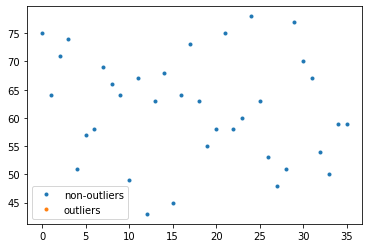

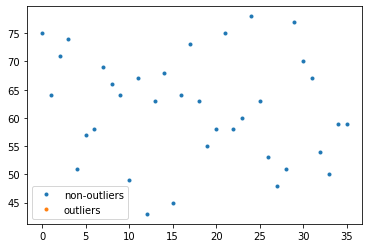

63.0 31.115411195577053 31.884588804422947 94.11541119557705


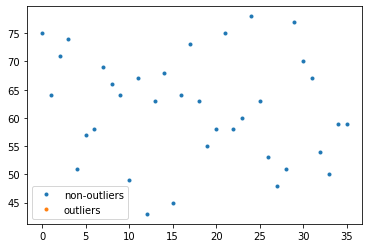

36 , 36


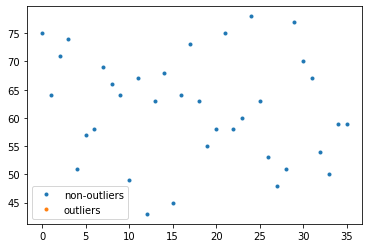

36 , 36


#### BSCS

3.38461538461538 1.3645740061059148 2.0200413785094655 4.749189390721295


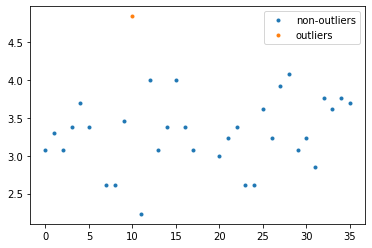

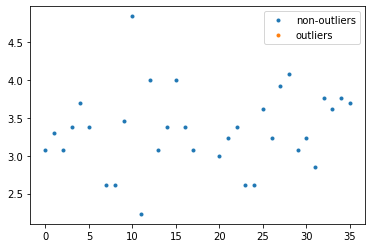

3.38461538461538 1.3645740061059148 2.0200413785094655 4.749189390721295


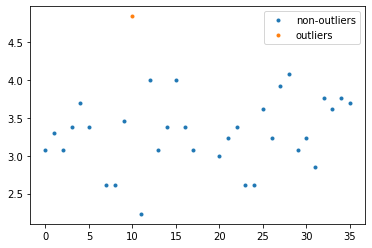

33 , 32
3.346153846153845 1.2781836354406706 2.0679702107131743 4.624337481594516


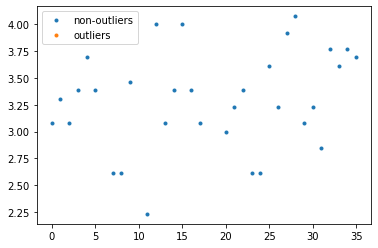

32 , 32


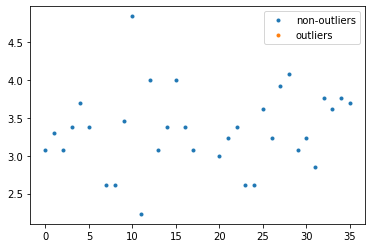

33 , 33


#### TESQ_E_suppression

8.0 8.86973103968853 -0.8697310396885296 16.86973103968853


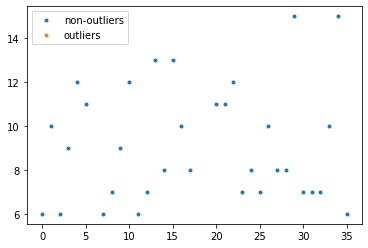

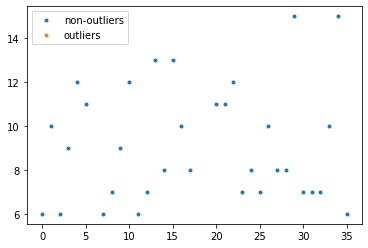

8.0 8.86973103968853 -0.8697310396885296 16.86973103968853


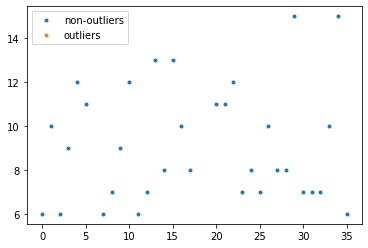

33 , 33


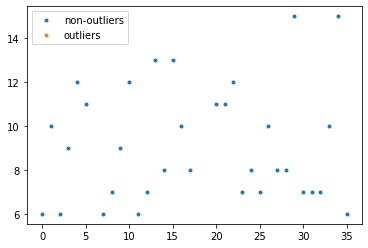

33 , 33


#### TESQ_E_avoidance_of_temptations

8.0 13.304596559532794 -5.3045965595327935 21.304596559532794


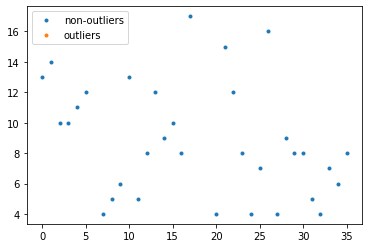

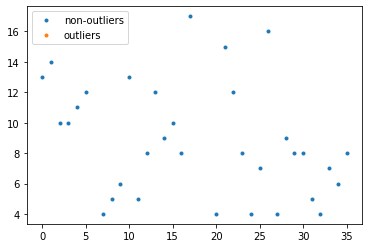

8.0 13.304596559532794 -5.3045965595327935 21.304596559532794


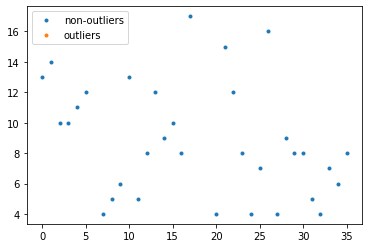

33 , 33


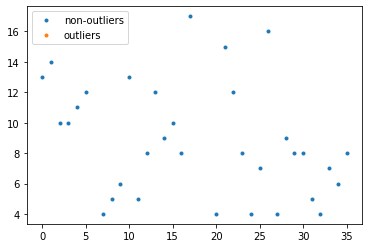

33 , 33


#### TESQ_E_goal_deliberation

9.0 11.087163799610662 -2.0871637996106625 20.087163799610664


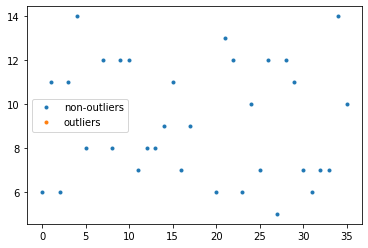

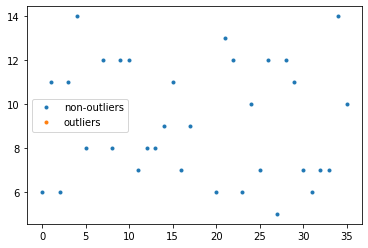

9.0 11.087163799610662 -2.0871637996106625 20.087163799610664


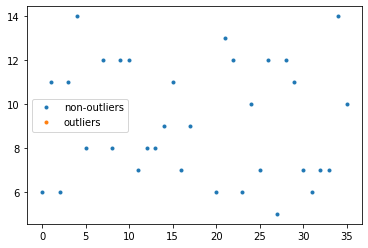

33 , 33


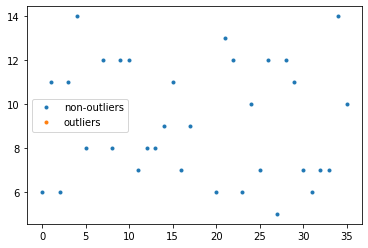

33 , 33


#### TESQ_E_controlling_temptations

9.0 8.86973103968853 0.1302689603114704 17.86973103968853


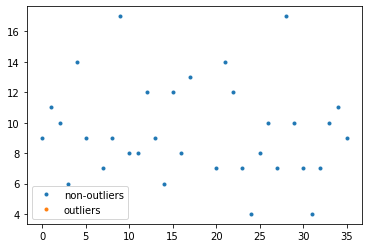

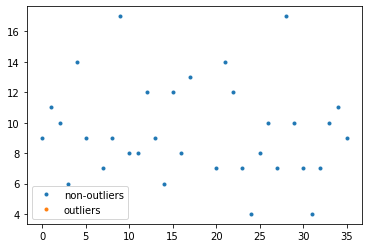

9.0 8.86973103968853 0.1302689603114704 17.86973103968853


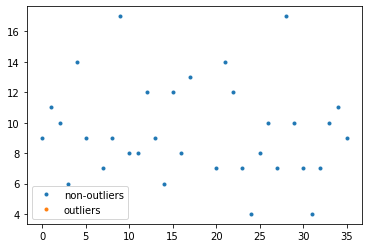

33 , 33


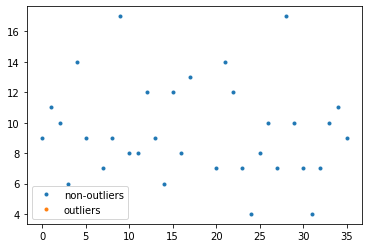

33 , 33


#### TESQ_E_distraction

7.0 8.86973103968853 -1.8697310396885296 15.86973103968853


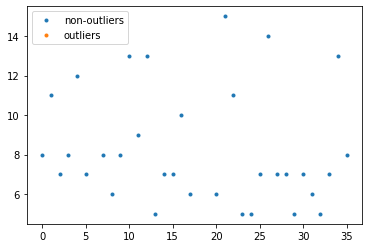

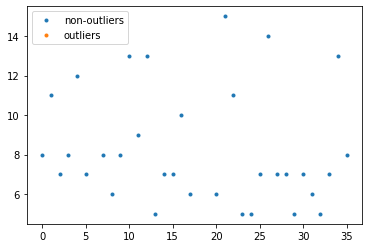

7.0 8.86973103968853 -1.8697310396885296 15.86973103968853


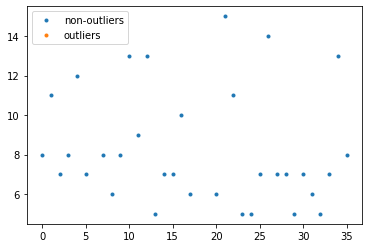

33 , 33


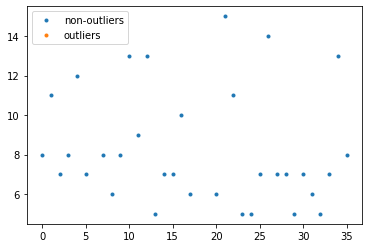

33 , 33


#### TESQ_E_goal_and_rule_setting

10.0 11.087163799610662 -1.0871637996106625 21.087163799610664


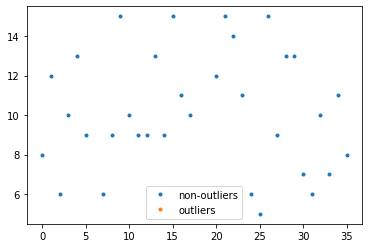

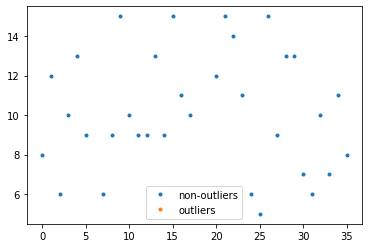

10.0 11.087163799610662 -1.0871637996106625 21.087163799610664


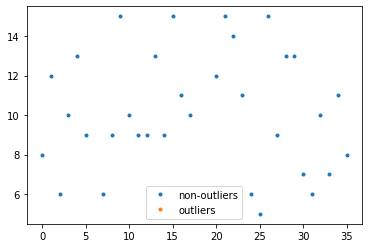

33 , 33


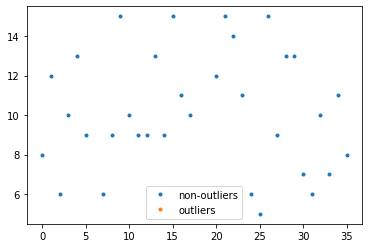

33 , 33


#### EDM

2.875 2.5003455425017274 0.37465445749827264 5.375345542501727


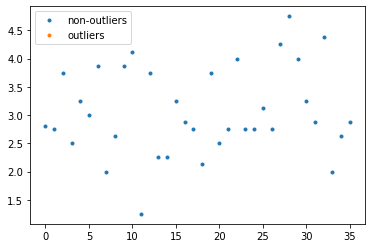

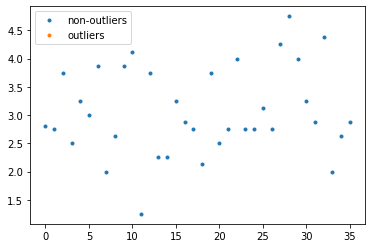

2.875 2.5003455425017274 0.37465445749827264 5.375345542501727


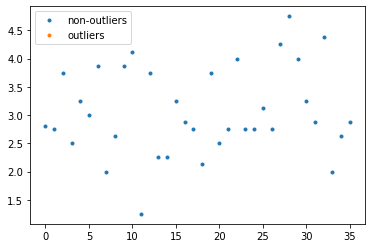

36 , 36


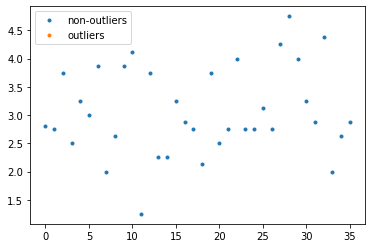

36 , 36


#### RS

17.0 15.546502488865595 1.4534975111344046 32.5465024888656


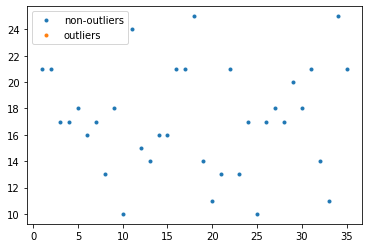

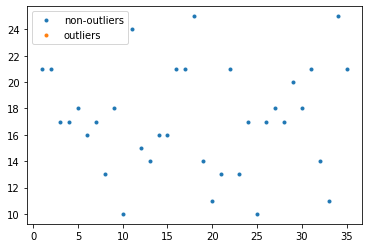

17.0 15.546502488865595 1.4534975111344046 32.5465024888656


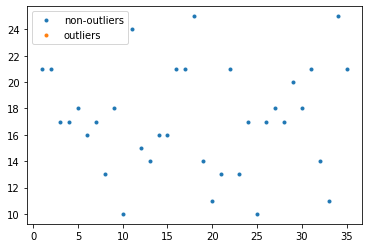

35 , 35


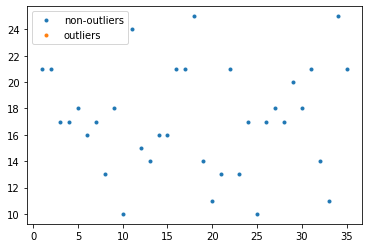

35 , 35


#### TRSQ

63.0 19.956894839299192 43.043105160700804 82.9568948392992


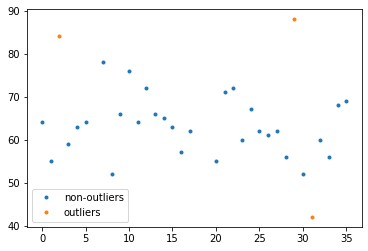

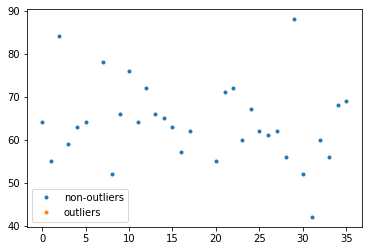

63.0 19.956894839299192 43.043105160700804 82.9568948392992


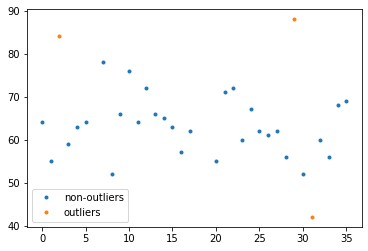

33 , 30
63.0 15.479101930062583 47.52089806993742 78.47910193006258


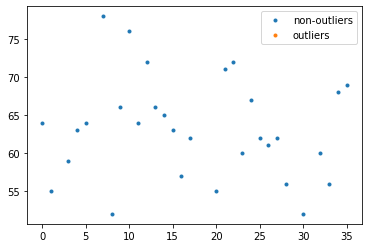

30 , 30


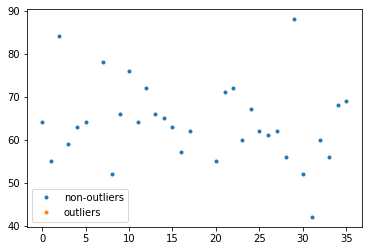

33 , 33


#### ROC_Crave_Regulate_Minus_Look

-1.1 2.0127168400763504 -3.1127168400763505 0.9127168400763503


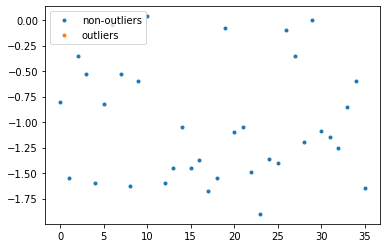

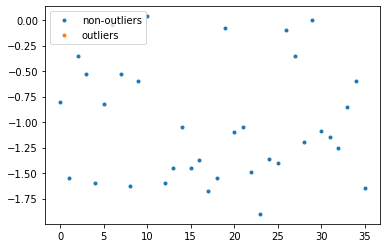

-1.1 2.0127168400763504 -3.1127168400763505 0.9127168400763503


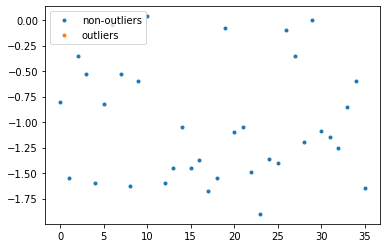

35 , 35


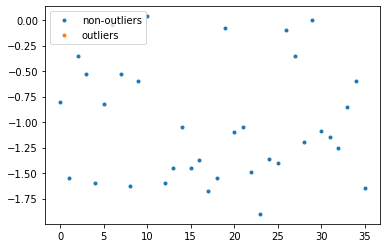

35 , 35


#### SRHI_unhealthy

46.0 31.044058638909853 14.955941361090147 77.04405863890986


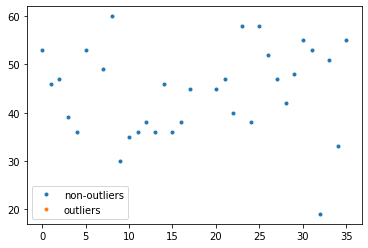

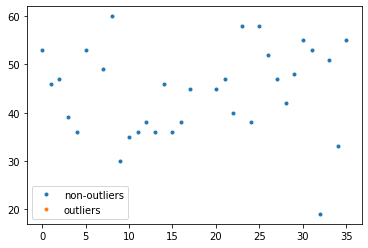

46.0 31.044058638909853 14.955941361090147 77.04405863890986


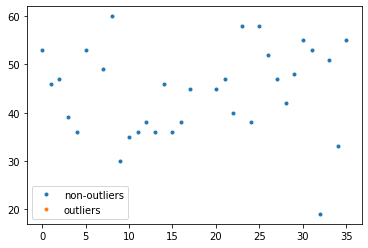

33 , 33


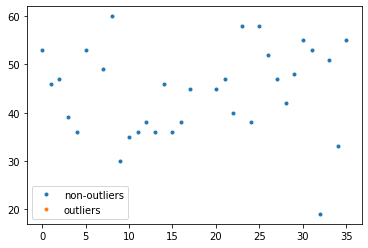

33 , 33


#### cancer_promoting_minus_preventing_FFQ

-0.32403846153845994 1.5386741800010577 -1.8627126415395177 1.2146357184625978


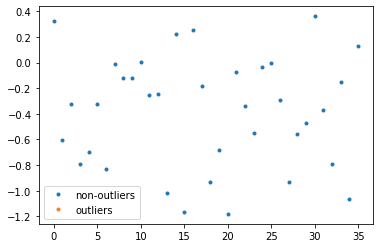

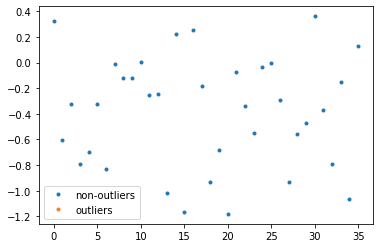

-0.32403846153845994 1.5386741800010577 -1.8627126415395177 1.2146357184625978


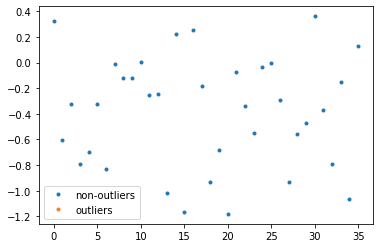

36 , 36


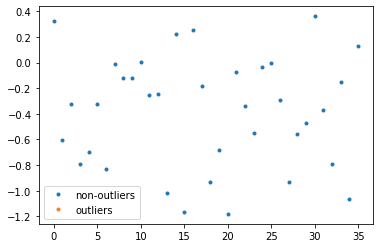

36 , 36


#### bf_1

40.75 18.335867311679333 22.414132688320667 59.08586731167934


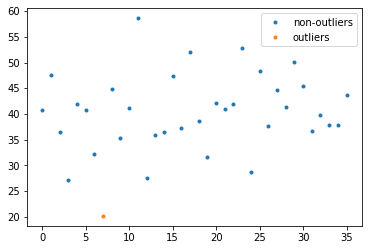

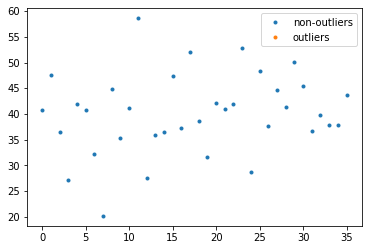

40.75 18.335867311679333 22.414132688320667 59.08586731167934


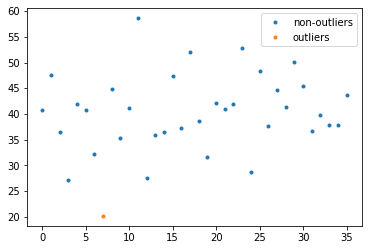

36 , 35
40.8 18.100570754893514 22.699429245106483 58.90057075489351


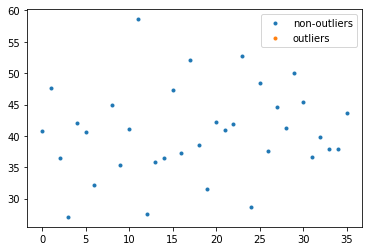

35 , 35


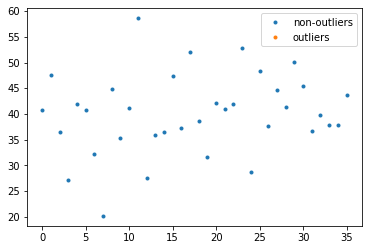

36 , 36


In [85]:
#from analyze_results import remove_selected_outliers


ind_div_combined_3sd = remove_selected_outliers_tesq_study(
    ind_div_combined,
    show_plot=True)

In [86]:
# probably repeat the whole process with some masks excluding, at a minimum, movement and visual cortices

In [79]:
from scipy.stats import pearsonr,spearmanr

### discriminability_overfit_accuracy

#### BFI_extraversion

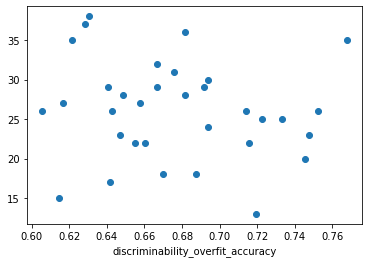

#### RMQ_locomotion

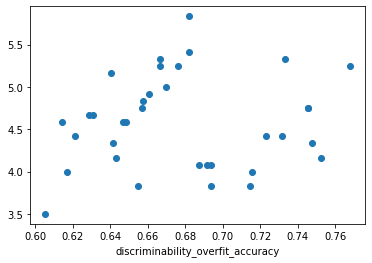

#### ses_aggregate

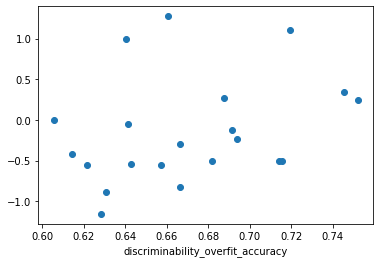

#### PLAN_cognitive_strategies

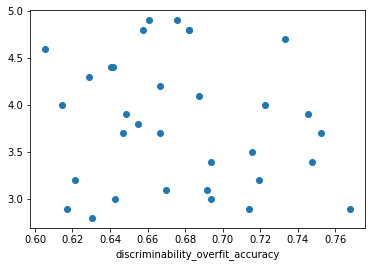

#### SST_SSRT

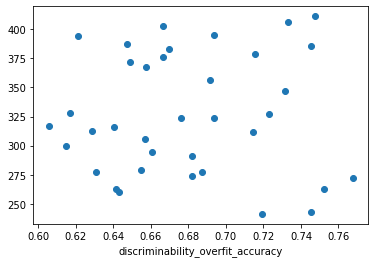

#### BIS_11

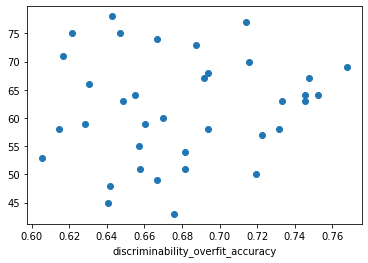

#### BSCS

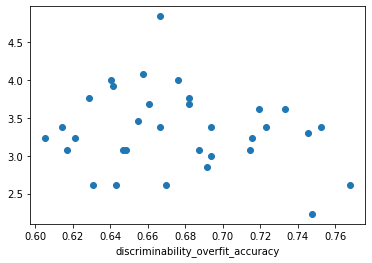

#### TESQ_E_suppression

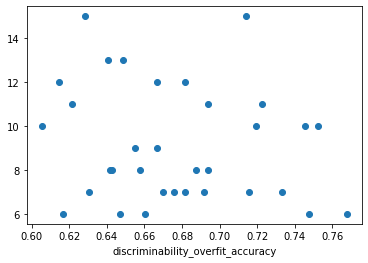

#### TESQ_E_avoidance_of_temptations

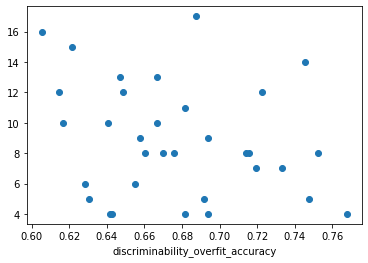

#### TESQ_E_goal_deliberation

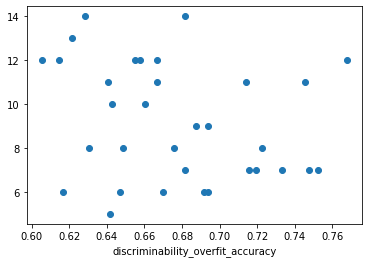

#### TESQ_E_controlling_temptations

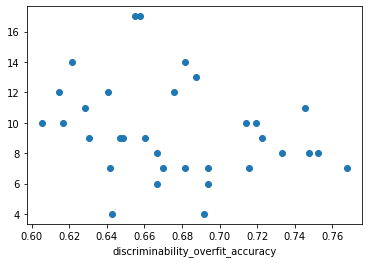

#### TESQ_E_distraction

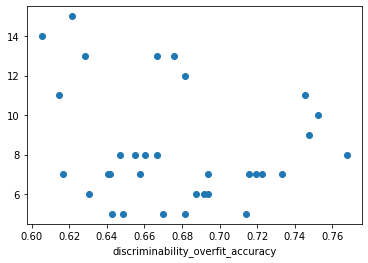

#### TESQ_E_goal_and_rule_setting

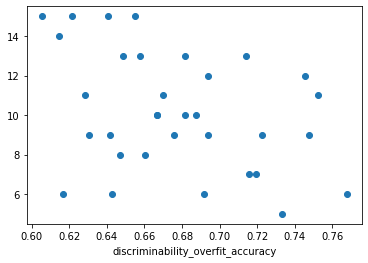

#### EDM

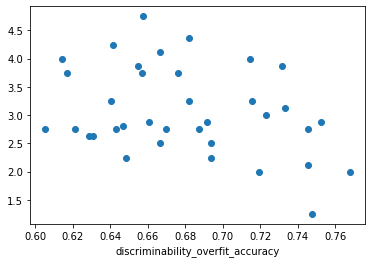

#### RS

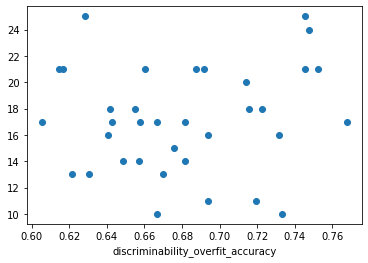

#### TRSQ

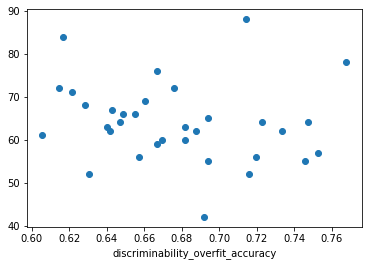

#### ROC_Crave_Regulate_Minus_Look

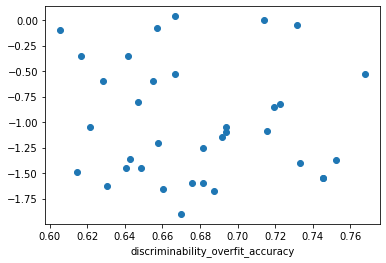

#### SRHI_unhealthy

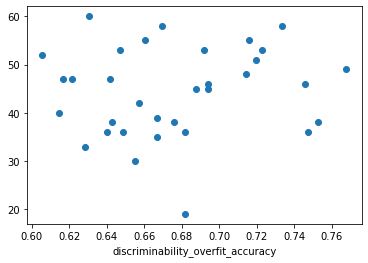

### discriminability_mean_cv_scores

#### BFI_extraversion

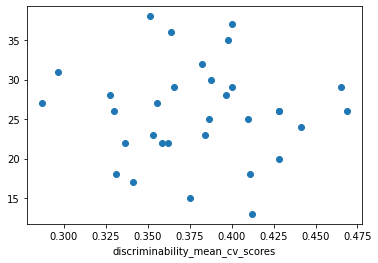

#### RMQ_locomotion

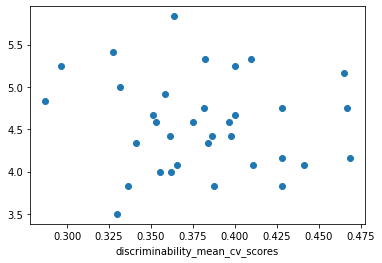

#### ses_aggregate

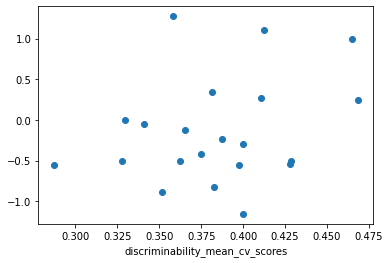

#### PLAN_cognitive_strategies

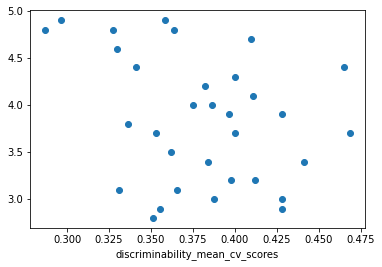

#### SST_SSRT

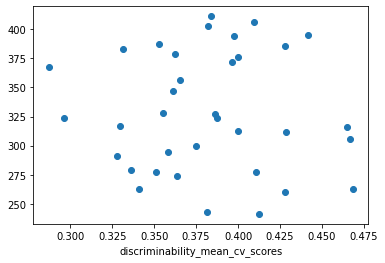

#### BIS_11

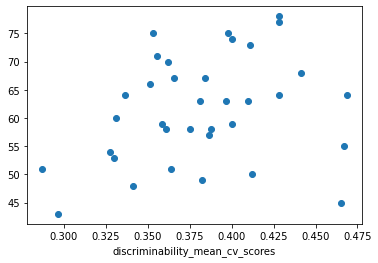

#### BSCS

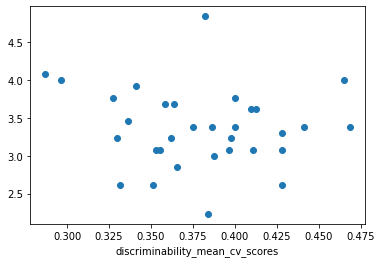

#### TESQ_E_suppression

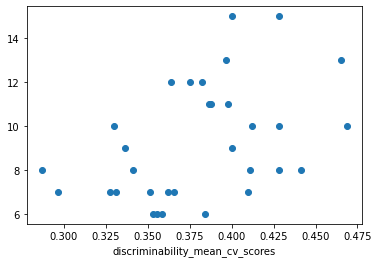

#### TESQ_E_avoidance_of_temptations

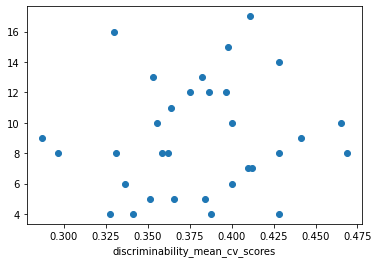

#### TESQ_E_goal_deliberation

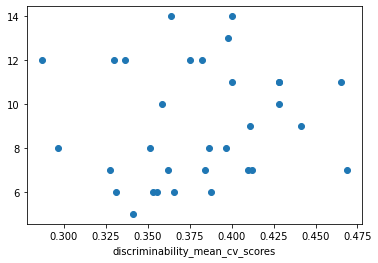

#### TESQ_E_controlling_temptations

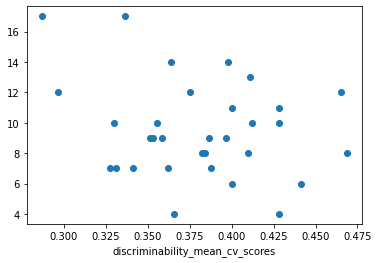

#### TESQ_E_distraction

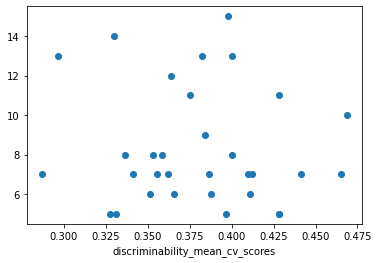

#### TESQ_E_goal_and_rule_setting

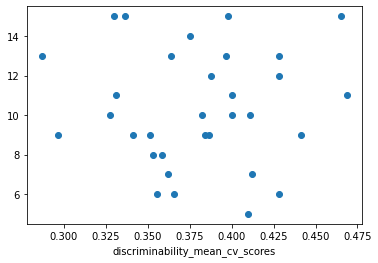

#### EDM

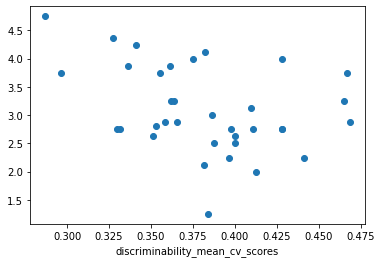

#### RS

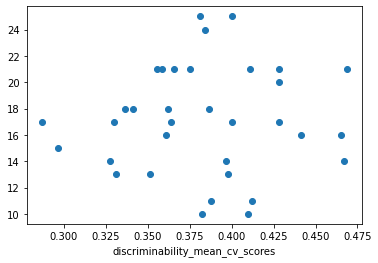

#### TRSQ

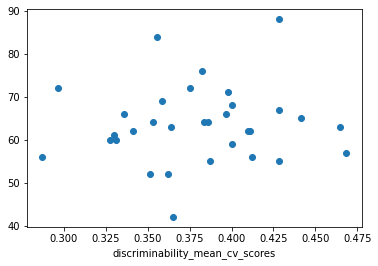

#### ROC_Crave_Regulate_Minus_Look

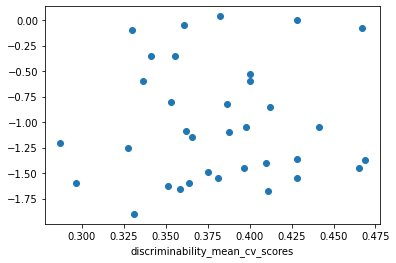

#### SRHI_unhealthy

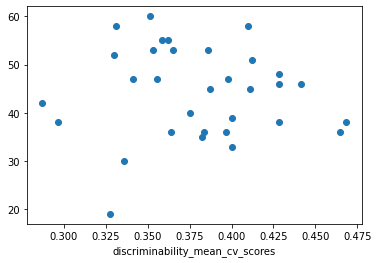

In [88]:
for neural_var in ['discriminability_overfit_accuracy','discriminability_mean_cv_scores']:
    display(Markdown("### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
        display(Markdown("#### " + correlate))
        nan_rows = np.isnan(ind_div_combined_3sd[correlate]) | np.isnan(ind_div_combined_3sd[neural_var])
        cor2way_df = ind_div_combined_3sd.loc[nan_rows==False,]
        pearson_result = pearsonr(cor2way_df[neural_var],cor2way_df[correlate])
        display(HTML("r=" + format(pearson_result[0],".2f") +"; p-value=" + format(pearson_result[1],".4f")))
        spearman_result = spearmanr(cor2way_df[neural_var],cor2way_df[correlate])
        display(HTML("rho=" + format(spearman_result[0],".2f") +"; p-value=" + format(spearman_result[1],".4f")))
        cplot = pyplot.scatter(cor2way_df[neural_var],cor2way_df[correlate])
        cplot.axes.set_xlabel(neural_var)
        cplot.axes.ylabel=correlate
        pyplot.show()

We actually have some values here but they don't survive multiple comparison correction. They might be worth a follow-up though--refining the method and trying again. We've only done the barest validation of the results.